In [ ]:
!pip3 install evaluate

In [9]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline
import torch
from datasets import Dataset, load_from_disk, DatasetDict
import evaluate
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score
import torch.nn.functional as F
from transformers import AutoConfig

import seaborn as sns
import matplotlib.pyplot as plt

from metrics_wrapper import MetricsWrapper


import math
import sqlite3
from transformers import AutoModelForMaskedLM
from transformers import DataCollatorForLanguageModeling

import pickle

## Import data and create 🤗 dataset

In [ ]:
annotated_df = pd.read_csv("data/flashback_annotated.tsv", sep="\t", index_col=0)

My reasoning for the split is as follows: I need the training set to be as large as possible, seeing that I want to give it more than a fair chance. In order for me to do that I need to have the split be large enough to accomodate another dev-split for the training set, in addition to the 15% taken for the test set. Additionally, I'll have to define a function which gives the test/train set the same proportion as the original.

In [117]:
def test_train_split(df: str, train_size=0.8, test_size=0.2):
    """ splits a dataframe to two randomly according to proportion of labels """
    assert test_size + train_size == 1
    np.random.seed(666)  # for reproducibility
    res = dict()
    SIZE = len(df)
    PROPORTION = len(df.loc[df["label"] == 1]) / SIZE

    # calculate how large each set should be
    SPLIT_TOTAL_SIZE = {"train": int(SIZE * train_size)}
    SPLIT_TOTAL_SIZE["test"] = SIZE - SPLIT_TOTAL_SIZE["train"]

    # define how many of each label for train set, calculated from proportion
    SPLIT_LABEL_SIZE = {"train": {"1": int(SPLIT_TOTAL_SIZE["train"] * PROPORTION)}}
    SPLIT_LABEL_SIZE["train"]["0"] = SPLIT_TOTAL_SIZE["train"] - SPLIT_LABEL_SIZE["train"]["1"]

    # for the test set we need to calculate them from the train set to avoid mismatch in sizes between labels
    SPLIT_LABEL_SIZE["test"] = {"1": len(df.loc[df["label"] == 1]) - SPLIT_LABEL_SIZE["train"]["1"]}
    SPLIT_LABEL_SIZE["test"]["0"] = len(df.loc[df["label"] == 0]) - SPLIT_LABEL_SIZE["train"]["0"]
    
    print(f"Split proportion: {SPLIT_LABEL_SIZE}\n\tSUM: train={sum(SPLIT_LABEL_SIZE['train'].values())}, test={sum(SPLIT_LABEL_SIZE['test'].values())}")
    arr_check = list()  # list just to make sure that we aren't adding posts to both train and test set
    for current_set in ["test", "train"]:
        df_subset = pd.DataFrame({'text': str(), 'label': int()}, index=[])

        # randomly choose indices to be dropped according to proportion
        idx_one = np.random.choice(
            df.loc[df['label'] == 1].index,
            size=SPLIT_LABEL_SIZE[current_set]["1"],
            replace=False
        )
        idx_zero = np.random.choice(
            df.loc[df['label'] == 0].index,
            size=SPLIT_LABEL_SIZE[current_set]["0"],
            replace=False
        )
        idx_arr = np.append(idx_one, idx_zero)
        arr_check.append(idx_arr)

        # extract rows, drop them from original df and add df_subset to result
        rows = df.loc[idx_arr]
        df = df.drop(idx_arr, axis=0)
        df_subset = pd.concat((df_subset, rows)).sample(frac = 1)
        res[current_set] = df_subset

    # double check that no posts are in both sets
    for i in arr_check[0]:
        for j in arr_check[1]:
            if i == j:
                print(f"ERROR: post present in both train and test set! [{i}]")
                return None
    return {"train": res["train"].reset_index(drop=True), "test": res["test"].reset_index(drop=True)}

In [118]:
dfs = test_train_split(annotated_df)
dfs["test"].to_csv("datasets/flashback_annotated_data_test_set.tsv", sep="\t", index=False)
dfs = test_train_split(dfs["train"])
dataset = DatasetDict({"train": Dataset.from_pandas(dfs["train"]), "test": Dataset.from_pandas(dfs["test"])})
dataset

Split proportion: {'train': {'1': 754, '0': 2478}, 'test': {'1': 189, '0': 619}}
	SUM: train=3232, test=808
Split proportion: {'train': {'1': 603, '0': 1982}, 'test': {'1': 151, '0': 496}}
	SUM: train=2585, test=647


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2585
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 647
    })
})

In [119]:
dataset.save_to_disk("datasets/flashback_annotated_dev_set")

Note that the test set is exported as a TSV, and will not be touched until the very end.

## Import finetuned masked LM model and add text classification head

### Finetuning

In [15]:
dataset = load_from_disk("datasets/flashback_annotated_dev_set")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2585
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 647
    })
})

In [ ]:
configuration = AutoConfig.from_pretrained("flashback_lm_model_larger_batch_size")
configuration.hidden_dropout_prob = 0.2
configuration.attention_probs_dropout_prob = 0.2

masked_lm_checkpoint = AutoModelForSequenceClassification.from_pretrained(
    "flashback_lm_model_larger_batch_size",
    config=configuration
)
tokenizer = AutoTokenizer.from_pretrained("flashback_lm_model_larger_batch_size")

The following is needed because it is wrongly set in the KB model

In [17]:
tokenizer.model_max_length = 512  # since this is incorrectly set in KB's model
tokenizer.model_max_length

512

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [19]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets

Loading cached processed dataset at datasets/flashback_annotated_dev_set/train/cache-1c80317fa3b1799d.arrow
Loading cached processed dataset at datasets/flashback_annotated_dev_set/test/cache-bdd640fb06671ad1.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2918
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 515
    })
})

In [23]:
batch_size = 16
# Show the training loss with every epoch
logging_steps = len(dataset["train"]) // batch_size
metric = evaluate.load("f1")

model_name = "bert-base-swedish-cased"  # just for naming checkpoint saves

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-classification-flashback",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.0005,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_accumulation_steps=1,  # slower, but less prone to overflow CUDA memory
    num_train_epochs=3,
    save_steps = 5000,
    logging_steps=logging_steps,
    save_strategy="no",  # I don't need to save model checkpoints when running experiments
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [24]:
trainer = Trainer(
    model=masked_lm_checkpoint,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [25]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 2918
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 549


Epoch,Training Loss,Validation Loss,F1
1,0.483600,0.442357,0.425532
2,0.384600,0.398810,0.580087
3,0.354900,0.416379,0.562500


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 515
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 515
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 515
  Batch size = 16


Training compl

TrainOutput(global_step=549, training_loss=0.3961040517671512, metrics={'train_runtime': 432.5692, 'train_samples_per_second': 20.237, 'train_steps_per_second': 1.269, 'total_flos': 2303274178621440.0, 'train_loss': 0.3961040517671512, 'epoch': 3.0})

In [30]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 515
  Batch size = 16


{'eval_loss': 0.43985089659690857,
 'eval_f1': 0.5520361990950227,
 'eval_runtime': 21.7128,
 'eval_samples_per_second': 23.719,
 'eval_steps_per_second': 1.52,
 'epoch': 3.0}

In [26]:
trainer.save_model("flashback_annotated_model")

Saving model checkpoint to flashback_annotated_model
Configuration saved in flashback_annotated_model/config.json
Model weights saved in flashback_annotated_model/pytorch_model.bin
tokenizer config file saved in flashback_annotated_model/tokenizer_config.json
Special tokens file saved in flashback_annotated_model/special_tokens_map.json


## Evaluation of model and wrong predictions

In order to evaluate different datasets we first define a pipeline:

In [4]:
annotated_model_pipeline = pipeline(
    "text-classification",
    model="flashback_annotated_model",
)

Then I created a wrapper for calculating and displaying metrics, which we can easily then use for all three test sets:

### Dev-set

In [4]:
dev_dataset = load_from_disk("datasets/flashback_annotated_dev_set")
dev_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2585
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 647
    })
})

In [5]:
dev_metrics = MetricsWrapper(annotated_model_pipeline, dev_dataset["test"])

precision: 0.75
recall: 0.50
f1_score: 0.60


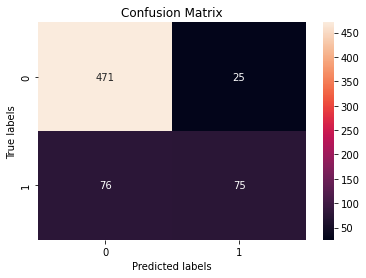

In [6]:
dev_metrics.display_metrics()

## Cross-domain scenario

### MLM

In [4]:
tokenizer = AutoTokenizer.from_pretrained('flashback_annotated_model')
tokenizer.model_max_length = 512
model_checkpoint = AutoModelForMaskedLM.from_pretrained('flashback_annotated_model')

Some weights of the model checkpoint at flashback_annotated_model were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at flashback_annotated_model and are newly initialized: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
You should pr

In [8]:
conn = sqlite3.connect("data/familjeliv.db")
with conn:
    pool_df = pd.read_sql_query("SELECT * FROM posts;", conn, index_col="id")
    pool_df = pool_df.sample(frac = 1, random_state = 666).reset_index(drop=True)
    pool_df["label"] = 0
    pool_df = pool_df[["text", "label"]]

mlm_dataset = DatasetDict({
    "train": Dataset.from_pandas(pool_df[:100000].reset_index(drop=True)),
    "test": Dataset.from_pandas(pool_df[100000:110000].reset_index(drop=True))
})

mlm_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10000
    })
})

In [9]:
def tokenize_function(document):
    """ returns tokenized document, quickly if tokenizer 'is fast' according to hf"""
    result = tokenizer(document["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

In [10]:
chunk_size = tokenizer.model_max_length

In [11]:
tokenized_datasets = mlm_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Parameter 'function'=<function tokenize_function at 0x7f381d9e2670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/100 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1033 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids'],
        num_rows: 10000
    })
})

In [12]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [13]:
mlm_dataset = tokenized_datasets.map(group_texts, batched=True)
mlm_dataset

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 14803
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1441
    })
})

In [14]:
batch_size = 12
# Show the training loss with every epoch
logging_steps = len(mlm_dataset["train"]) // batch_size
model_name = "bert-base-swedish-cased"

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-familjeliv-annotated",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_accumulation_steps=1,  # slower, but less prone to overflow CUDA memory
    num_train_epochs=15,
    save_strategy="no",  # not necessary here
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model_checkpoint,
    args=training_args,
    train_dataset=mlm_dataset["train"],
    eval_dataset=mlm_dataset["test"],
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15),
    tokenizer=tokenizer,
)

In [18]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14803
  Num Epochs = 15
  Instantaneous batch size per device = 12
  Total train batch size (w. parallel, distributed & accumulation) = 12
  Gradient Accumulation steps = 1
  Total optimization steps = 18510


Epoch,Training Loss,Validation Loss
1,4.223100,3.067340
2,3.185600,2.646385
3,2.907200,2.483813
4,2.743700,2.398205
5,2.646900,2.303165
6,2.584000,2.252323
7,2.528000,2.241017
8,2.488400,2.210090
9,2.458500,2.179126
10,2.426200,2.178417


The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12
The following columns in the evaluation set don't have a corresponding argument in `BertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `BertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1441
  Batch size = 12
The following columns in the evaluation set don't have a corresponding ar

TrainOutput(global_step=18510, training_loss=2.672153714229969, metrics={'train_runtime': 13847.7417, 'train_samples_per_second': 16.035, 'train_steps_per_second': 1.337, 'total_flos': 5.845682072489472e+16, 'train_loss': 2.672153714229969, 'epoch': 15.0})

In [20]:
trainer.save_model("familjeliv_mlm_annotated")

Saving model checkpoint to familjeliv_mlm_annotated
Configuration saved in familjeliv_mlm_annotated/config.json
Model weights saved in familjeliv_mlm_annotated/pytorch_model.bin
tokenizer config file saved in familjeliv_mlm_annotated/tokenizer_config.json
Special tokens file saved in familjeliv_mlm_annotated/special_tokens_map.json


Unfortunately, this seemed to reduce the models performance in the context of cross-domain scenarios.

## Metrics

### Baseline

In [5]:
flashback_testset = pd.read_csv("datasets/flashback_annotated_data_test_set.tsv", sep="\t")
flashback_testset = Dataset.from_pandas(flashback_testset)
flashback_testset

Dataset({
    features: ['text', 'label'],
    num_rows: 808
})

In [6]:
baseline_metrics = MetricsWrapper(annotated_model_pipeline, flashback_testset)

precision: 0.79
recall: 0.60
f1_score: 0.68


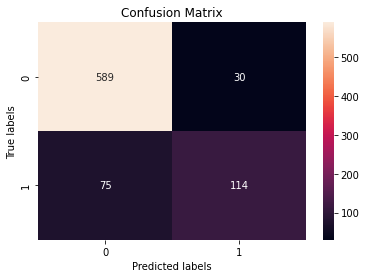

In [7]:
baseline_metrics.display_metrics()

In [10]:
with open("metrics/flashback_annotated_metrics.pkl", "wb") as f:
    pickle.dump(baseline_metrics, f)

### Cross-domain

In [11]:
familjeliv_automatic_pipeline = pipeline(
    "text-classification",
    model="familjeliv_mlm_annotated",
)
familjeliv_testset = DatasetDict.load_from_disk("datasets/familjeliv_testset")

In [12]:
familjeliv_testset_metrics = MetricsWrapper(familjeliv_automatic_pipeline, familjeliv_testset["test"])

In [15]:
with open("metrics/familjeliv_annotated_metrics.pkl", "wb") as f:
    pickle.dump(familjeliv_testset_metrics, f)